## How to do prior and posterior predictive checks in a multinomial-softmax regression

In chapter 4 we introduced softmax regression and showed that (see `model_sf` in the chapter) the most efficient way to model multinomial data is to artificially fix one of the predicted categories to zero (on the parameter space, not on the probability space, of course). If we don't do that, the model will be over-parametrized: since the sum of all the categories' probabilities must sum to 1, the last one is determined once we know all the other. 

What happens if we put all the categories into the model (as in `model_s` in the chapter)? Well, it is so dangerous that no one ever dared trying... Kidding aside, the model will probably run with no divergences - as NUTS is good at dealing with high correlations in the posterior. But it will be slow and inefficient. In other words, we can do better - so let's do it!

Of course, we've already done that in the chapter, so here we'll extend the example and show you how to do prior and posterior predictive checks in a multinomial-softmax regression. These are harder than usual both because of the softmax link that distorts the relation between the parameter space and the outcome space, and because all the probabilities are linked together (if one goes up, another one *must* go down). Let's dive in!

In [1]:
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
iris = sns.load_dataset("iris")

y_s = pd.Categorical(iris["species"]).codes

x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

x_s.shape, y_s.shape, np.unique(y_s)

((150, 4), (150,), array([0, 1, 2], dtype=int8))

Let's start with prior predictive checks. It's the easiest: as we'll give the same prior to all 3 categories, we need not concern ourselves with the softmax part yet. A simple logistic regression for one category and a representative range for one of the four predictors should give us a good idea of the behavior of our prior in the probability space. Here what this bad boy looks like:

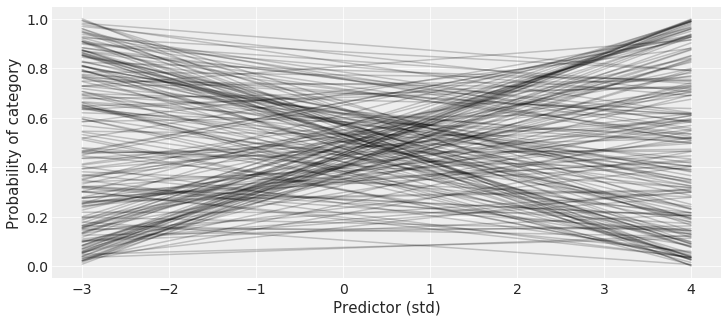

In [3]:
plt.figure(figsize=(12, 5))
a_s = pm.Normal.dist(mu=0.0, sd=1.0).random(size=200)
b_s = pm.Normal.dist(mu=0.0, sd=0.5).random(size=200)

for θ_s in zip(logistic(a_s - 3 * b_s), logistic(a_s + 4 * b_s)):
    plt.plot([-3, 4], θ_s, color="k", alpha=0.2)

plt.xlabel("Predictor (std)")
plt.ylabel("Probability of category");

What do these priors say - apart from paying a hidden tribute to the X-men? We can say they are "weakly regularizing" priors, because they bound the lines to possible ranges of the variables, while still allowing some implausibly strong relationships.

We could maybe regularize even more - in fact I encourage you to change the priors for `a_s` and `b_s` above to see the consequences on the outcome space - but these priors should allow smooth sampling of the model:

In [4]:
with pm.Model() as model_sf:
    α = pm.Normal("α", mu=0.0, sd=1.0, shape=2)
    α_f = tt.concatenate([[0], α])

    β = pm.Normal("β", mu=0.0, sd=0.5, shape=(4, 2))
    β_f = tt.concatenate([np.zeros((4, 1)), β], axis=1)

    X = pm.Data("X", x_s)
    μ = α_f + pm.math.dot(X, β_f)
    θ = pm.Deterministic("θ", tt.nnet.softmax(μ))

    yl = pm.Categorical("yl", p=θ, observed=y_s)

    trace_sf = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_sf, round_to=2, var_names=["α", "β"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:37<00:00, 159.98draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],0.86,0.32,0.26,1.45,0.01,0.01,2040.74,1949.57,2043.08,1290.38,1.0
α[1],-0.40,0.45,-1.25,0.41,0.01,0.01,2078.15,1643.39,2079.00,1689.96,1.0
"β[0,0]",0.78,0.34,0.14,1.40,0.01,0.01,1507.99,1419.97,1504.05,1342.31,1.0
"β[0,1]",0.85,0.36,0.20,1.51,0.01,0.01,1690.25,1548.60,1696.44,1557.86,1.0
"β[1,0]",-1.04,0.27,-1.53,-0.53,0.01,0.00,2312.29,2162.90,2327.35,1463.43,1.0
"β[1,1]",-0.58,0.33,-1.17,0.04,0.01,0.01,2302.81,1920.29,2306.19,1620.59,1.0
"β[2,0]",0.81,0.38,0.11,1.51,0.01,0.01,1953.75,1664.09,1970.73,1520.09,1.0
"β[2,1]",1.62,0.44,0.84,2.48,0.01,0.01,1667.52,1667.52,1664.72,1188.90,1.0
"β[3,0]",0.30,0.37,-0.40,0.97,0.01,0.01,1755.85,1455.68,1764.94,1328.86,1.0
"β[3,1]",1.98,0.40,1.24,2.74,0.01,0.01,1742.11,1731.07,1735.90,1478.57,1.0


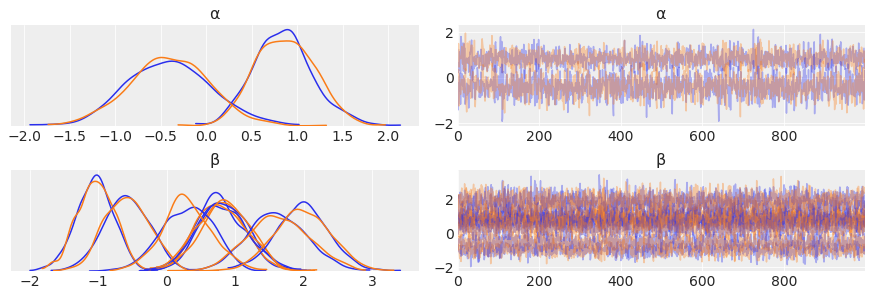

In [5]:
az.plot_trace(trace_sf, var_names=["α", "β"], compact=True);

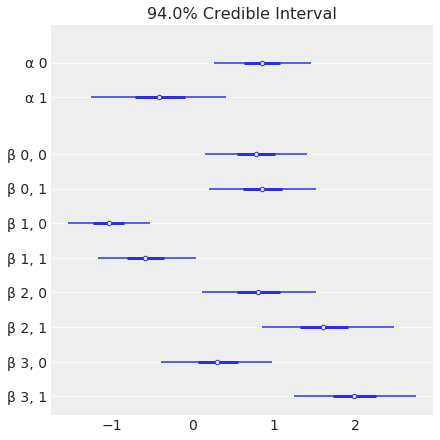

In [6]:
fig, axes = az.plot_forest(trace_sf, var_names=["α", "β"], combined=True)
axes[0].grid();

Everything looks fine. Now let's tackle what we came for: posterior predictive checks! We'll draw two types of PPC here, starting by what Richard McElreath calls "counterfactual plots". These show how predictions change when only one predictor varies and other predictors are held constant.

So, in the function below, only one predictor of interest (`mobile_pred`) is allowed to vary across a wide range of values ([-3, 4]), while the other three predictors are held constant at 0 (their mean value - remember, they are standardized). We then sample posterior predictive probabilities from the model, with these new `X` values. This means we get 500 samples for each category's probability under the new counterfactual conditions. The plots then display the change in probability across values of the predictor of interest and... tadaaaa!

In [7]:
def counterfact_plots(mobile_pred: str):
    """
    Plots the change in each category's predicted probability across values of a single predictor, 
    holding the other predictors constant at 0 (their mean value, as they are standardized).
    Shaded regions show 94% compatibililty intervals of the probabilities.
    mobile_pred: name of one of the four predictors contained in array x_n. This predictor is then
    allowed to vary from -3 to 4, which represents quite a wide range as the predictors are std.
    """
    # hold predictors at 0, except for mobile_pred:
    idx_pred = np.where(x_n == mobile_pred)[0][0]
    l, h = np.zeros(len(x_n)), np.zeros(len(x_n))
    l[idx_pred], h[idx_pred] = -3, 4
    predictor_seq = np.linspace(l, h)

    # compute counterfactual probabilities (θ):
    with model_sf:
        pm.set_data({"X": predictor_seq})
        post_checks = pm.sample_posterior_predictive(
            trace_sf, var_names=["θ"], random_seed=RANDOM_SEED
        )["θ"]
    θ_mean = post_checks.mean(0)

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    i = 0
    for ax in axes:
        ax.plot(predictor_seq[:, idx_pred], θ_mean[:, i])
        az.plot_hpd(predictor_seq[:, idx_pred], post_checks[:, :, i], ax=ax)
        ax.set_ylim([0, 1])
        ax.set_xlabel(f"{mobile_pred} (std)")
        ax.set_ylabel(f"Probability of {iris.species.unique()[i]}")
        ax.set_title("Other predictors (std) = 0")
        i += 1

100%|██████████| 2000/2000 [00:01<00:00, 1312.91it/s]


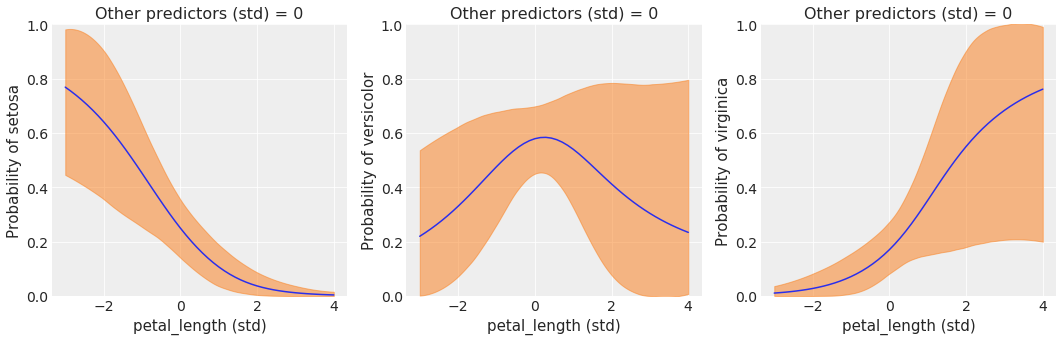

In [8]:
counterfact_plots("petal_length")

Pretty neat, uh?! These plots help us understand the model's implications, which is hugely valuable when your model has several predictors and dimensions. Keep in mind though that these predictons are *counterfactual*: they display predictions for impossible combinations of predictor values - in the real world, it's probably very difficult to vary petal length without affecting petal width for instance.

These plots are lacking one type of information however: they don't compare the model's predictions against raw data. Let's do that, now that we have a better understanding of the posterior distribution. The idea is to plot predictions against observed data, to see if the model correctly approximates the posterior distribution, and where the model fails. That's what the appropriately named "posterior predictive plots" do.

Before that though, let's compute what percentage of predictions we got right, to get a sense of whether the model's predictions fit the raw data:

In [9]:
θ_pred = trace_sf["θ"].mean(0)
f"{np.mean(y_s == np.argmax(θ_pred, axis=1)):.2f}"

'0.94'

So, on average, we associated each point to its real category 94% of the time - pretty good! Remember though that we're not aiming for 100% accuracy here: this would reflect over-fitting, as we're talking about in-sample predictions here. Our regularizing priors from the beggining are precisely here to help with that: they tend to reduce in-sample fit to improve out-of-sample predictions.

That being said, let's visually compare our predictions against the raw data. First, let's set the predictors back to their original values and generate posterior predictive samples:

In [10]:
with model_sf:
    pm.set_data({"X": x_s})
    post_checks = pm.sample_posterior_predictive(trace_sf, random_seed=RANDOM_SEED)

100%|██████████| 2000/2000 [00:28<00:00, 71.23it/s]


As it turns out, ArviZ has a very convenient function to plot PPCs:

/anaconda/envs/fund/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda/envs/fund/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


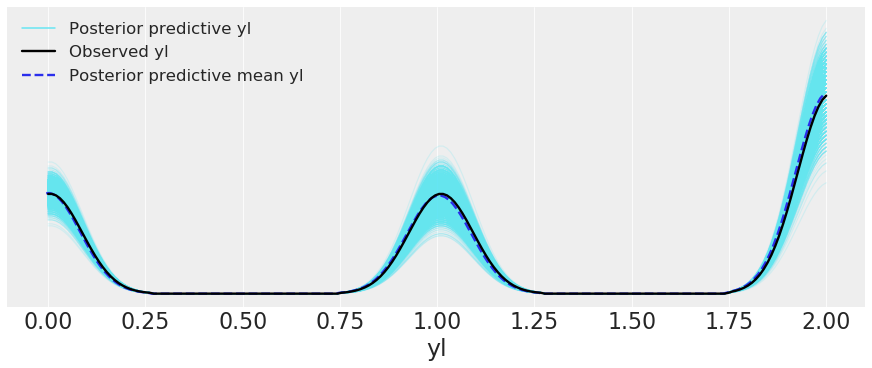

In [11]:
idata = az.from_pymc3(trace=trace_sf, posterior_predictive=post_checks)
az.plot_ppc(idata, random_seed=RANDOM_SEED, figsize=(12, 5));

A note before going on: this plot uses KDEs (which assumes a continuous distribution) for a categorical distribution (which is discrete). That is why you see 3 bumps at 0, 1 and 2 (the only three values that `yl` can take) and a density of 0 for all other `yl` values. You're probably used to seeing these graphs with histograms. We can't do that with `az.plot_ppc`, but here it's quite easy to understand both the plot and the discretness of the distribution. Still curious? Try passing `kind="cumulative"` or `kind="scatter"` to `az.plot_ppc` and see what comes up...

But what is this plot telling us? That the model did a very good job at approximating the posterior distribution, basically - the 3 curves are a perfect match for each other. But this plot doesn't tell us where the model fails. To see that, we have to plot the individual data points:

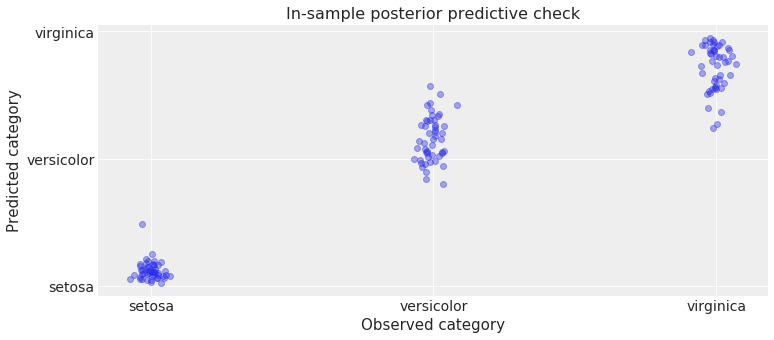

In [12]:
y_pred = post_checks["yl"].mean(0)
jitter = np.random.normal(0, 0.03, len(y_s))

plt.figure(figsize=(12, 5))
plt.scatter(y_s + jitter, y_pred, alpha=0.4)
plt.xticks(range(3), iris.species.unique())
plt.xlabel("Observed category")
plt.yticks(range(3), iris.species.unique())
plt.ylabel("Predicted category")
plt.title("In-sample posterior predictive check");

We see that the model does a very good job at predicting setosa flowers, but seems to have trouble differentiating versicolor from virginica - it regularly mixes up one for the other. This suggests that these two species are close regarding the features we included into the model. If we had a finer view of what tells them apart, we could get this information into the model and improve our predictions - and understanding. How do we do that? Well, we're no botanists, so that's where domain knowledge comes into play.

More generally, this notebook focused on how to inspect the gut of your model for not-so-simple models, like mutinomial regressions. But we did not think causally here to determine which predictors to regress on. That's ok for a notebook that aims to give a technical view, but if you want to go beyond mere predictions - e.g understanding the process and intervening in the real world based on your model's insights - then you'll need a causal graph before doing any modeling.

You're still there? Well, thanks for reading! As we are (still) mere mortals, we may have forgotten about important aspects or made mistakes - so please, send your pull requests our way on this repo. And above all, live long & PyMCheers!

In [13]:
%watermark -a AlexAndorra -n -u -v -iv -w

arviz      0.5.1
theano     1.0.4
seaborn    0.9.0
pandas     0.25.1
matplotlib 3.1.1
numpy      1.16.5
pymc3      3.7
AlexAndorra 
last updated: Thu Oct 17 2019 

CPython 3.7.4
IPython 7.8.0
watermark 2.0.1
